# NEURAL NETWORKS AND DEEP LEARNING
---
### A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---

Segalini Beatrice, student ID 1234430

> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
-----


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [1]:
# !pip install rich

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from scipy.stats import loguniform 

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import imageio

from rich.jupyter import print
from tqdm import tqdm

# reproducibility, use Student ID as seed
torch.manual_seed(1234430)    
np.random.seed(1234430)

Download the dataset:

In [3]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

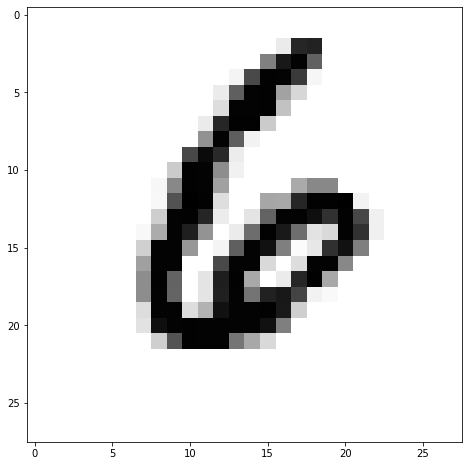

In [4]:
sample_index = 13
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [5]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

To transform a PIL Image directly to a PyTorch tensor, instead:

In [6]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

## Define network main structure

In [7]:
class CNN(nn.Module):
    '''
    Module including network structure and functioning, basic training, testing and validating operations.
    '''
    def __init__(self, n_channels, pdrop2d, pdrop1d):
        '''
        The network is composed of:
        - one convolutional layer with 1 input channel, @n_channels output channels, a 3 by 3 kernel 
        - another convolutional layer with @n_channels input channels, 2*@n_channels output channels, 5 by 5 kernel
        - a dropout layer
        - one fully connected layer with (img size)x(2*n_channels)=50xn_channels inputs, 100 outputs
        - another dropout layer
        - one fully connected layer with 100 inputs, 10 outputs (corresponding to the 10 labels)  
        
        Input
        n_channels: number of convolutional channels
        pdrop2d:    dropout probability of 2D dropout layer
        pdrop1d:    dropout probability of 1D dropout layer
        '''
        super(CNN, self).__init__()
    
        # --> img size = 28-3+2*1+1= 28x28 
        self.conv1 = nn.Conv2d(1, n_channels, kernel_size=3, padding=1)
        # Max Pooling --> img size halved = 14x14
        self.mpool = nn.MaxPool2d(2, 2)    
        # dropout layer
        self.drop2 = nn.Dropout2d(p=pdrop2d) 
        # --> img size = 14-5+1 = 10x10
        self.conv2 = nn.Conv2d(n_channels, 2*n_channels, kernel_size=5) 
        # Max Pooling --> img size halved = 5x5
        
        # fully connceted layer with (img size)x(2*n_channels)=50xn_channels, 100 output units
        self.fulc1 = nn.Linear(50*n_channels, 100)             
        # dropout after first linear layer
        self.drop1 = nn.Dropout(p=pdrop1d)
        # fully connected layer with inputs equal to number of outputs of previous layer, 10 outputs (10 digits)
        self.fulc2 = nn.Linear(100, 10)
        
        print('Network initialized')

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.mpool(x)
        x = F.relu(self.conv2(x))
        x = self.mpool(x)
        x = self.drop2(x)
        x = x.view(x.size(0), -1) # reshaping necessary for linear layer
        x = F.relu(self.fulc1(x))
        x = self.drop1(x)
        x = self.fulc2(x)
        
        return x
    
    def train_step(self, train_loader, optimizer, loss_func, device, epoch, verbose=False):
        """
        Define the basic train step.
        
        train_loader: dataloader
        optimizer:    type of selected optimizer (SGD, Adam...)
        loss_func:    selected loss function
        device:       gpu (if available) or cpu
        epoch:        number of epoch in training process
        verbose:      if True prints out status of training process, default False
        
        Return: training loss.
        """
        
        train_loss = [] #initialize vector containing training losses
        self.train()    #set training mode
        
        for ii, s_batch in enumerate(train_loader):
            
            x_batch = s_batch[0].to(device)       #import data, move to device 
            label_b = s_batch[1].to(device)       #import labels, move to device
            
            for_out = self.forward(x_batch)       #forward pass
            
            tr_loss = loss_func(for_out, label_b) #compute loss
        
            self.zero_grad()                      #back-propagation
            tr_loss.backward()
            
            optimizer.step()                      #weights update
                
            ba_loss = tr_loss.detach().cpu().numpy()
            train_loss.append(ba_loss)            #save loss for batch
            
            if (ii % 10 == 0 and verbose): # every 10 batches print out a sumary of training results
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, ii * len(s_batch[0]), len(train_loader.dataset),
                    100. * ii / len(train_loader), ba_loss))

        return train_loss
    
    
    def val_step(self, valid_loader, loss_func, device):
        """
        Define basic validation step.
        
        valid_loader: dataloader
        loss_func:    selected loss function
        device:       gpu (if available) or cpu
        
        Return: validation loss, validation accuracy.
        """
        val_loss = [] #initialize vector containing validation losses
        self.eval()   #set evaluation mode
        
        with torch.no_grad():                         #disable gradient tracking
            for s_batch in valid_loader:
                
                x_batch = s_batch[0].to(device)       #import data, move to device
                label_b = s_batch[1].to(device)       #import labels, move to device
            
                for_out = self.forward(x_batch)       #forward pass

                va_loss = loss_func(for_out, label_b) #compute loss

                ba_loss = va_loss.detach().cpu().numpy()
                val_loss.append(ba_loss)           #save loss for batch
        
        return val_loss
    
    def fitting(self, train_loader, val_loader, optimizer, loss_func, verbose, param):
        '''
        Define training process.
        
        train_loader: train set dataloader 
        valid_loader: validation set dataloader
        optimizer:    selected optimizer 
        loss_func:    selected loss function
        verbose:      if True prints out training status during training process
        param:        dictionary containing the rest of the parameters
        
        Return: train and validation losses.
        '''
        
        train_loss_log = [] 
        val_loss_log = []
        
        for epoch in tqdm(range(param['num_epochs'])):
            # Training
            train_loss = self.train_step(train_loader, optimizer, loss_func, 
                                         param['device'], epoch, verbose)
                
            # Compute and store average training loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
            
            # Validation 
            valid_loss = self.val_step(val_loader, loss_func, param['device'])
            
            # Compute and store average validation loss
            valid_loss = np.mean(valid_loss)
            val_loss_log.append(valid_loss)
            
            # Check for early stopping condition
            stop = self._early_stopping(val_loss_log, param['num_epochs'])
            if stop: 
                print('Early stopping at epoch ', epoch)
                param['num_epochs'] = epoch
                break
            
        return train_loss_log, val_loss_log
    
    def predicting(self, data_loader, device):
        '''
        Compute and returns predicted labels.
        '''              
                
        predicts = [] #initialize vector containing predictions
        self.eval()   #set evaluation mode
        
        with torch.no_grad():                   #disable gradient tracking
            for s_batch in tqdm(data_loader):
                
                x_batch = s_batch[0].to(device) #import data, move to device
                
                for_out = self.forward(x_batch) #forward pass

                outputs = for_out.cpu().numpy().argmax()
                predicts.append(outputs)        #save predictions
        
        return np.array(predicts)
                    
    def _early_stopping(self, val_loss_log, num_epochs):
        
        stop = False
        
        if len(val_loss_log)>1:
            # set interval dimension in which to check loss values
            range_loss = min(len(val_loss_log), 10)
            last_loss = val_loss_log[-1]
            mean_loss = np.mean(val_loss_log[-range_loss:-1])
            
            if (np.abs(last_loss-mean_loss) < 0.005): 
                stop = True
                
        return stop


## Prepare datasets and dataloaders


In [8]:
# Initial parameters
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.9

# when downloading the datasets, performs two basic transformations, composing them:
#  - ToTensor() as usual
#  - Normalize((0.1307,), (0.3081,)) to normalise data mean providing mean and standard deviation respectively 

norm_transf = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize( (0.1307,), (0.3081,))] )

train_dataset_full = torchvision.datasets.MNIST('classifier_data', train=True, 
                                                download=True, transform=norm_transf)
test_dataset       = torchvision.datasets.MNIST('classifier_data', train=False, 
                                                download=True, transform=norm_transf)

In [9]:
# prepare validation set by splitting the train one
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset_full, [int(0.8*len(train_dataset_full)),int(0.2*len(train_dataset_full))])

print('Train samples:', len(train_dataset), '\nValidation samples:', len(valid_dataset), '\nTest samples:', len(test_dataset))

# set up dataloaders
train_load = Data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
valid_load = Data.DataLoader(valid_dataset, batch_size=batch_size_train, shuffle=False)

test_load  = Data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

## Random parameters selection

In [10]:
def random_params(params):
    selected_params = {}
    for i in params.keys():
        selected_params[i] = np.random.choice( params[i] )
    return selected_params

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

params = {"device"        : [device],
          "num_epochs"    : [n_epochs],
          "n_channels"    : np.arange(3,11), 
          "pdrop1d"       : np.random.uniform(0, 0.25, 20),
          "pdrop2d"       : np.random.uniform(0, 0.25, 20),
          "optimizer"     : ['sgd', 'adam'],
          "momentum"      : np.random.uniform(0.5, 0.95, 20),
          "learning_rate" : loguniform.rvs(1e-5, 1e-2, size=20),
          "reg_param"     : loguniform.rvs(1e-4, 1e-1, size=20),
          }

print('Random network parameters:', random_params(params))

## Selecting the best model: random search

In [11]:
def random_search(grid_pars, train_loader, valid_loader, n_models):
    '''
    Random parameter search for selecting optimal network
    
    grid_pars    : dictionary containing all the parameters on which to perform the random search
    train_loader : dataloader for training set
    valid_loader : dataloader for validation set
    n_models     : number of models tested, i.e. number of iterations 
    
    Returns: train and validation losses and network parameters
    '''
    
    # initialise outputs
    net_params = []
    train_loss_log = []
    val_loss_log = []
    
    verbose = False # we don't need intermediate training steps
    
    for i in tqdm(range(n_models)):
        
        # select random parameters
        params = random_params(grid_pars)
        
        print('Model ', i+1)
        print('Network parameters:', params)
        
        # initialize network
        net = CNN(params['n_channels'], params['pdrop2d'], params['pdrop1d'] )
        net.to(params['device'])
        
        # initialize loss function
        loss_func = nn.CrossEntropyLoss() 
        # set up optimizer
        if params['optimizer']=='adam':
            optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], 
                             weight_decay=params['reg_param'])
        elif params['optimizer']=='sgd':
            optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], 
                            momentum=params['momentum'], weight_decay=params['reg_param'])
        
        # training & validation process
        train_loss, valid_loss = net.fitting(train_loader, valid_loader, optimizer, 
                                             loss_func, verbose, params)
        
        train_loss_log.append(train_loss)
        val_loss_log.append(valid_loss)
        
        # append final to parameter dictionnary  final loss for each model studied
        params['final_loss'] = valid_loss[-1]
        net_params.append(params)
        
    return net_params, train_loss_log, val_loss_log

In [12]:
# perform random search!
net_params, train_loss_rs, valid_loss_rs = random_search(params, train_load, valid_load, 50)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


  2%|█▋                                                                                 | 1/50 [00:35<29:13, 35.78s/it]

  2%|█▋                                                                                 | 1/50 [01:11<58:24, 71.52s/it]


 24%|███████████████████▋                                                              | 12/50 [05:26<17:22, 27.44s/it]

  4%|███▏                                                                            | 2/50 [07:02<3:08:57, 236.20s/it]


 30%|████████████████████████▌                                                         | 15/50 [07:19<17:04, 29.26s/it]

  6%|████▊                                                                           | 3/50 [14:49<4:27:24, 341.37s/it]


  8%|██████▏                                                                       | 4/50 [50:03<13:18:05, 1040.99s/it]


 30%|████████████████████████▌                                                         | 15/50 [10:37<24:48, 42.54s/it]

 10%|███████▋                                                                     | 5/50 [1:01:20<11:22:30, 910.01s/it]


  8%|██████▋                                                                            | 4/50 [02:42<31:48, 41.50s/it]

 12%|█████████▎                                                                    | 6/50 [1:04:50<8:12:45, 671.95s/it]


 28%|██████████████████████▉                                                           | 14/50 [10:19<26:31, 44.21s/it]

 14%|██████████▉                                                                   | 7/50 [1:15:53<7:59:24, 668.95s/it]


 26%|█████████████████████▎                                                            | 13/50 [07:05<20:12, 32.77s/it]

 16%|████████████▍                                                                 | 8/50 [1:23:33<7:01:49, 602.61s/it]


 18%|█████████████▊                                                               | 9/50 [1:48:34<10:03:31, 883.21s/it]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [20:30<00:51, 25.75s/it]

 20%|███████████████▏                                                            | 10/50 [2:09:32<11:05:55, 998.89s/it]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [17:21<07:09, 28.64s/it]

 22%|████████████████▌                                                          | 11/50 [2:27:24<11:03:58, 1021.49s/it]


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [27:38<07:27, 40.72s/it]

 24%|██████████████████                                                         | 12/50 [2:55:45<12:57:48, 1228.11s/it]


  6%|████▉                                                                              | 3/50 [02:13<35:41, 45.57s/it]

 26%|████████████████████                                                         | 13/50 [2:58:49<9:22:14, 911.75s/it]


 26%|█████████████████████▎                                                            | 13/50 [08:54<25:35, 41.51s/it]

 28%|█████████████████████▌                                                       | 14/50 [3:08:26<8:06:29, 810.81s/it]


 46%|█████████████████████████████████████▋                                            | 23/50 [16:10<19:10, 42.63s/it]

 30%|███████████████████████                                                      | 15/50 [3:25:17<8:28:07, 871.08s/it]


 50%|█████████████████████████████████████████                                         | 25/50 [17:39<17:26, 41.87s/it]

 32%|████████████████████████▋                                                    | 16/50 [3:43:41<8:53:21, 941.22s/it]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [17:49<06:19, 29.17s/it]

 34%|██████████████████████████▏                                                  | 17/50 [4:01:58<9:03:25, 988.04s/it]


 36%|███████████████████████████▎                                                | 18/50 [4:22:13<9:23:15, 1056.11s/it]


 24%|███████████████████▋                                                              | 12/50 [05:36<17:36, 27.80s/it]

 38%|█████████████████████████████▎                                               | 19/50 [4:28:18<7:18:24, 848.52s/it]


 16%|█████████████▎                                                                     | 8/50 [03:19<17:34, 25.11s/it]

 40%|██████████████████████████████▊                                              | 20/50 [4:32:01<5:30:28, 660.96s/it]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [19:23<00:24, 24.29s/it]

 42%|████████████████████████████████▎                                            | 21/50 [4:51:50<6:35:59, 819.29s/it]


 36%|█████████████████████████████▌                                                    | 18/50 [08:55<15:55, 29.87s/it]

 44%|█████████████████████████████████▉                                           | 22/50 [5:01:16<5:46:54, 743.37s/it]


 44%|████████████████████████████████████                                              | 22/50 [09:28<12:03, 25.83s/it]

 46%|███████████████████████████████████▍                                         | 23/50 [5:11:10<5:14:19, 698.48s/it]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [15:09<06:30, 26.02s/it]

 48%|████████████████████████████████████▉                                        | 24/50 [5:26:45<5:33:25, 769.44s/it]


 26%|█████████████████████▎                                                            | 13/50 [06:33<18:41, 30.30s/it]

 50%|██████████████████████████████████████▌                                      | 25/50 [5:33:48<4:37:20, 665.63s/it]


 52%|████████████████████████████████████████                                     | 26/50 [5:52:22<5:20:03, 800.14s/it]


  8%|██████▋                                                                            | 4/50 [01:18<15:03, 19.65s/it]

 54%|█████████████████████████████████████████▌                                   | 27/50 [5:54:01<3:45:59, 589.54s/it]


  4%|███▎                                                                               | 2/50 [00:55<22:07, 27.66s/it]

 56%|███████████████████████████████████████████                                  | 28/50 [5:55:33<2:41:27, 440.33s/it]


 58%|████████████████████████████████████████████▋                                | 29/50 [6:10:56<3:24:51, 585.31s/it]


 10%|████████▎                                                                          | 5/50 [02:15<20:35, 27.45s/it]

 60%|██████████████████████████████████████████████▏                              | 30/50 [6:13:53<2:34:13, 462.67s/it]


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [16:35<05:14, 26.20s/it]

 62%|███████████████████████████████████████████████▋                             | 31/50 [6:30:55<3:19:36, 630.36s/it]


 30%|████████████████████████▌                                                         | 15/50 [04:47<11:10, 19.16s/it]

 64%|█████████████████████████████████████████████████▎                           | 32/50 [6:36:01<2:39:59, 533.32s/it]


 36%|█████████████████████████████▌                                                    | 18/50 [04:53<08:45, 16.42s/it]

 66%|██████████████████████████████████████████████████▊                          | 33/50 [6:41:11<2:12:04, 466.17s/it]


 46%|█████████████████████████████████████▋                                            | 23/50 [06:13<07:18, 16.25s/it]

 68%|████████████████████████████████████████████████████▎                        | 34/50 [6:47:40<1:58:10, 443.18s/it]


 36%|█████████████████████████████▌                                                    | 18/50 [06:00<10:46, 20.21s/it]

 70%|█████████████████████████████████████████████████████▉                       | 35/50 [6:54:01<1:46:04, 424.27s/it]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [12:00<04:12, 19.41s/it]

 72%|███████████████████████████████████████████████████████▍                     | 36/50 [7:06:21<2:01:07, 519.08s/it]


 60%|█████████████████████████████████████████████████▏                                | 30/50 [10:22<07:58, 23.94s/it]

 74%|████████████████████████████████████████████████████████▉                    | 37/50 [7:17:06<2:00:38, 556.81s/it]


 36%|█████████████████████████████▌                                                    | 18/50 [09:48<17:24, 32.65s/it]

 76%|██████████████████████████████████████████████████████████▌                  | 38/50 [7:27:27<1:55:15, 576.28s/it]


 78%|████████████████████████████████████████████████████████████                 | 39/50 [7:52:47<2:37:33, 859.40s/it]


 24%|███████████████████▋                                                              | 12/50 [04:25<14:07, 22.31s/it]

 80%|█████████████████████████████████████████████████████████████▌               | 40/50 [7:57:40<1:54:52, 689.26s/it]


 22%|██████████████████                                                                | 11/50 [03:57<14:27, 22.24s/it]

 82%|███████████████████████████████████████████████████████████████▏             | 41/50 [8:01:57<1:23:58, 559.82s/it]


 84%|████████████████████████████████████████████████████████████████▋            | 42/50 [8:17:23<1:29:16, 669.54s/it]


 34%|███████████████████████████▉                                                      | 17/50 [08:25<16:39, 30.30s/it]

 86%|██████████████████████████████████████████████████████████████████▏          | 43/50 [8:26:18<1:13:23, 629.14s/it]


 88%|███████████████████████████████████████████████████████████████████▊         | 44/50 [8:44:43<1:17:11, 771.95s/it]


 90%|█████████████████████████████████████████████████████████████████████▎       | 45/50 [9:02:17<1:11:22, 856.51s/it]


 20%|████████████████▍                                                                 | 10/50 [03:36<14:19, 21.50s/it]

 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [9:06:15<44:43, 670.84s/it]


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [9:24:14<39:40, 793.40s/it]


 32%|██████████████████████████▏                                                       | 16/50 [05:11<11:11, 19.74s/it]

 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [9:29:44<21:48, 654.31s/it]


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [9:46:44<12:44, 764.11s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [10:13:45<00:00, 736.51s/it]


<Figure size 432x288 with 0 Axes>

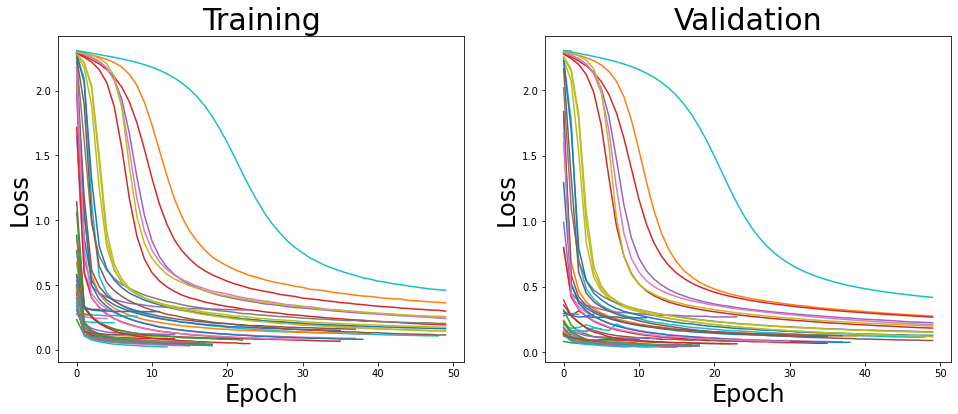

In [13]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

for tr_l in train_loss_rs:
    ax[0].plot(tr_l)
    
ax[0].set_ylabel('Loss', fontsize=24)
ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_title('Training', fontsize=30)

for val in valid_loss_rs:
    ax[1].plot(val)
    
ax[1].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_title('Validation', fontsize=30)

plt.savefig('MNIST_tr_val_loss.png')
plt.show()

<Figure size 432x288 with 0 Axes>

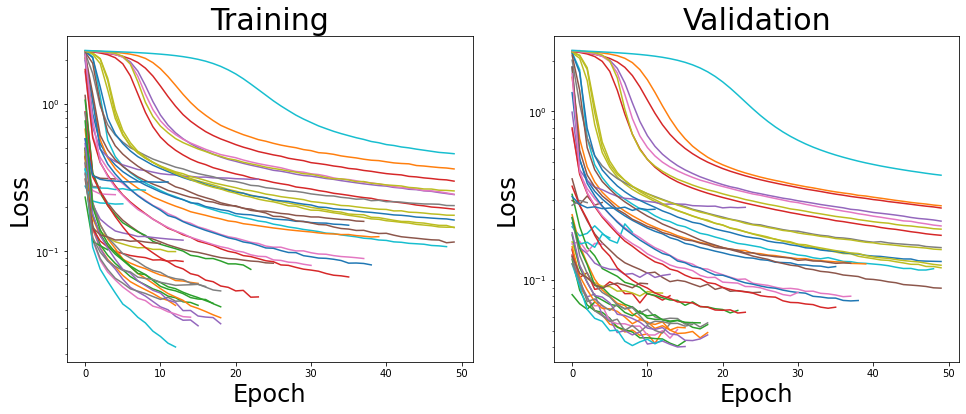

In [14]:
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

for tr_l in train_loss_rs:
    ax[0].semilogy(tr_l)
    
ax[0].set_ylabel('Loss', fontsize=24)
ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_title('Training', fontsize=30)

for val in valid_loss_rs:
    ax[1].semilogy(val)
    
ax[1].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_title('Validation', fontsize=30)

plt.savefig('MNIST_tr_val_loss_log.png')
plt.show()

In [38]:
avg_val_loss = [np.mean(vl) for vl in valid_loss_rs]
min_val_loss = [vl[-1] for vl in valid_loss_rs]
print('Minimum average validation losses (top 10):', np.sort(avg_val_loss)[:10])
print(np.argmin(avg_val_loss))
print(np.argmin(min_val_loss))

In [16]:
record_losses = open('train_losses_random_search.txt', 'w') 
for ll in train_loss_rs:
    record_losses.write(str(ll) + '\n')
record_losses.close()

In [17]:
record_losses = open('valid_losses_random_search.txt', 'w') 
for ll in valid_loss_rs:
    record_losses.write(str(ll) + '\n')
record_losses.close()

#### Compute average train and validation loss

In [18]:
for ii, pars in enumerate(net_params):
    pars['avg_train_loss'] = np.mean(train_loss_rs[ii])
    pars['avg_valid_loss'] = np.mean(valid_loss_rs[ii])
    pars.pop('device')   # remove device parameter before saving the grid search results
    for k in pars.keys():
        if k!= 'optimizer':
            pars[k] = float(pars[k]) 
    
# for i in net_params[0].keys():
#     print(type(net_params[0][i]))

print(net_params)

### Save random search results...

In [19]:
import json
filename = open("MNIST_random_search_params.json", "w")
json.dump(net_params, filename)
filename.close()

### ... and load them

In [20]:
# with open('MNIST_random_search_params.json', 'r') as fp:
#     net_params = json.load(fp)

## Select best net
Choose the one with the minimum average validation loss.

In [21]:
best_net = net_params[np.argmin([i['avg_valid_loss'] for i in net_params])]
print('Best network parameters:', best_net)

## Test ``final_net`` performances

In [23]:
# use full train set to train, test set to validate model
train_load_full = Data.DataLoader(train_dataset_full, batch_size=batch_size_train, shuffle=True)

# initialize network
final_net = CNN(int(best_net['n_channels']), best_net['pdrop2d'], best_net['pdrop1d'] )
final_net.to(device)
        
# initialize loss function
loss_func = nn.CrossEntropyLoss() 

# set up optimizer
if best_net['optimizer']=='adam':
    optimizer = optim.Adam(final_net.parameters(), lr=best_net['learning_rate'], 
                     weight_decay=best_net['reg_param'])
elif best_net['optimizer']=='sgd':
    optimizer = optim.SGD(final_net.parameters(), lr=best_net['learning_rate'], 
                    momentum=best_net['momentum'], weight_decay=best_net['reg_param'])
    
best_net['num_epochs'] = 50
best_net['device'] = device
verbose = True # see training process checkpoints

# Training and testing
best_train_loss, best_test_loss = final_net.fitting(train_load_full, test_load, optimizer,
                                                    loss_func, verbose, best_net)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:26<22:02, 27.00s/it]

  4%|███▎                                                                               | 2/50 [00:56<22:52, 28.59s/it]

  6%|████▉                                                                              | 3/50 [01:26<22:52, 29.20s/it]

  8%|██████▋                                                                            | 4/50 [02:02<24:27, 31.90s/it]

 10%|████████▎                                                                          | 5/50 [02:31<23:06, 30.81s/it]

 12%|█████████▉                                                                         | 6/50 [03:07<23:47, 32.45s/it]

 14%|███████████▌                                                                       | 7/50 [03:37<22:42, 31.68s/it]

 16%|█████████████▎                                                                     | 8/50 [04:13<23:13, 33.17s/it]

 18%|██████████████▉                                                                    | 9/50 [04:45<22:20, 32.70s/it]

 20%|████████████████▍                                                                 | 10/50 [05:18<21:56, 32.91s/it]

 22%|██████████████████                                                                | 11/50 [05:55<22:13, 34.20s/it]

 22%|██████████████████                                                                | 11/50 [06:27<22:54, 35.25s/it]


<Figure size 432x288 with 0 Axes>

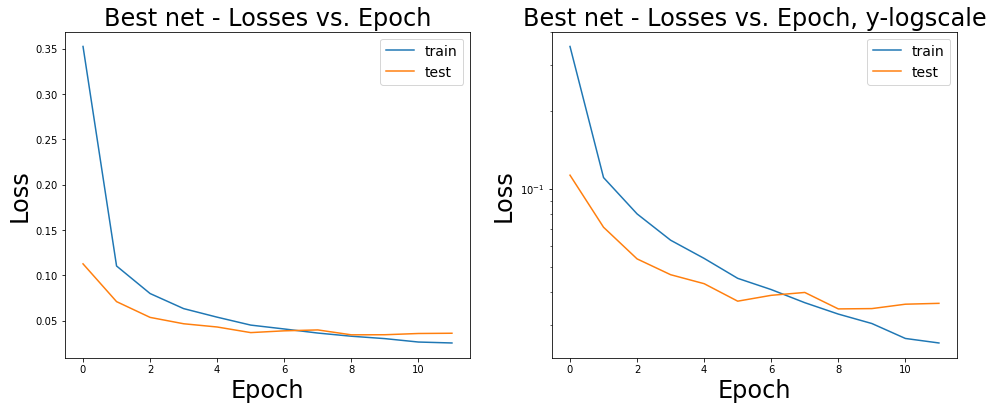

In [24]:
# Plot training results
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_ylabel('Loss', fontsize=24)

ax[0].set_title('Best net - Losses vs. Epoch', fontsize=24)
ax[0].plot(best_train_loss, label='train')
ax[0].plot(best_test_loss, label='test')
ax[0].legend(loc='best', fontsize=14)

ax[1].set_title('Best net - Losses vs. Epoch, y-logscale', fontsize=24)
ax[1].semilogy(best_train_loss, label='train')
ax[1].semilogy(best_test_loss, label='test')
ax[1].legend(loc='best', fontsize=14)

plt.savefig('MNIST_tr_test_loss_BEST.png')
plt.show()

In [25]:
# store best parameters
net_state_dict = final_net.state_dict()
torch.save(net_state_dict, 'MNIST_best_net_parameters.torch')
# save the optimizer state
torch.save(optimizer.state_dict(), 'MNIST_optimizer_state.torch')

In [26]:
def testing(network, test_loader, loss_func, device):
    '''
    Define testing procedure, given a trained @network, a dataloader @test_loader and a loss function @loss_func.
    
    network:     trained network
    test_loader: test set dataloader 
    loss_func:   selected loss function
    device:      gpu (if available) or cpu
    
    Return: average test loss and test accuracy.        
    '''

    network.eval()  #set evaluation mode
    
    # define support variables
    corrects  = 0.
    totals    = 0.
    test_loss = 0.
    
    with torch.no_grad():
        for s_batch in test_loader:
            
            x_batch = s_batch[0].to(device)       #import data, move to device
            label_b = s_batch[1].to(device)       #import labels, move to device !!![1][0]????
            
            outputs = network(x_batch)
            
            test_loss += loss_func(outputs, label_b).item()
            
            _, predicted = torch.max(outputs.data, 1)
            totals += label_b.size(0)
            corrects += (predicted == label_b).sum().item()
        
        accuracy = (corrects / totals) * 100
        avg_test_loss = test_loss / totals
        
        print('\n Average test loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    avg_test_loss, corrects, totals, accuracy))
           
    return avg_test_loss, accuracy

final_avg_test_loss, accuracy = testing(final_net, test_load, loss_func, device)

## Test another net ``final_net2``
Test also the one with the minimum validation loss at the end of the training process. 

In [40]:
best_net2 = net_params[np.argmin([i['final_loss'] for i in net_params])]
print('Best network parameters:', best_net2)

# use full train set to train, test set to validate model
train_load_full = Data.DataLoader(train_dataset_full, batch_size=batch_size_train, shuffle=True)

# initialize network
final_net2 = CNN(int(best_net2['n_channels']), best_net2['pdrop2d'], best_net2['pdrop1d'] )
final_net2.to(device)
        
# initialize loss function
loss_func = nn.CrossEntropyLoss() 

# set up optimizer
if best_net2['optimizer']=='adam':
    optimizer = optim.Adam(final_net2.parameters(), lr=best_net2['learning_rate'], 
                     weight_decay=best_net2['reg_param'])
elif best_net2['optimizer']=='sgd':
    optimizer = optim.SGD(final_net2.parameters(), lr=best_net2['learning_rate'], 
                    momentum=best_net2['momentum'], weight_decay=best_net2['reg_param'])
    
best_net2['num_epochs'] = 50
best_net2['device'] = device
verbose = True # see training process checkpoints

# Training and testing
best_train_loss2, best_test_loss2 = final_net2.fitting(train_load_full, test_load, optimizer,
                                                      loss_func, verbose, best_net2)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:41<33:29, 41.01s/it]

  4%|███▎                                                                               | 2/50 [01:28<35:47, 44.74s/it]

  6%|████▉                                                                              | 3/50 [02:05<32:18, 41.24s/it]

  8%|██████▋                                                                            | 4/50 [02:47<31:57, 41.68s/it]

 10%|████████▎                                                                          | 5/50 [03:30<31:38, 42.20s/it]

 12%|█████████▉                                                                         | 6/50 [04:07<29:32, 40.28s/it]

 14%|███████████▌                                                                       | 7/50 [04:50<29:27, 41.11s/it]

 16%|█████████████▎                                                                     | 8/50 [05:35<29:38, 42.35s/it]

 18%|██████████████▉                                                                    | 9/50 [06:13<27:57, 40.92s/it]

 20%|████████████████▍                                                                 | 10/50 [06:55<27:39, 41.48s/it]

 22%|██████████████████                                                                | 11/50 [07:40<27:37, 42.51s/it]

 24%|███████████████████▋                                                              | 12/50 [08:23<26:55, 42.50s/it]

 24%|███████████████████▋                                                              | 12/50 [09:04<28:44, 45.38s/it]


In [47]:
# store best parameters
net_state_dict2 = final_net2.state_dict()
torch.save(net_state_dict2, 'MNIST_best_net_parameters2.torch')
# save the optimizer state
torch.save(optimizer.state_dict(), 'MNIST_optimizer_state2.torch')

<Figure size 432x288 with 0 Axes>

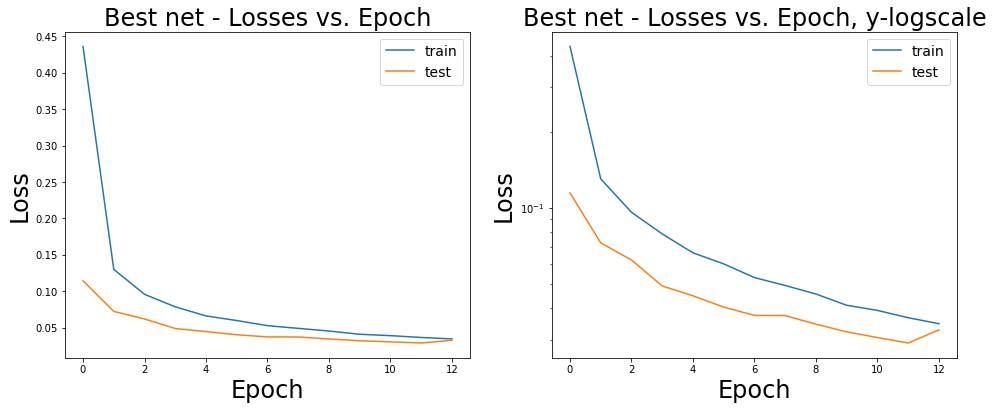

In [41]:
# Plot training results
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_ylabel('Loss', fontsize=24)

ax[0].set_title('Best net - Losses vs. Epoch', fontsize=24)
ax[0].plot(best_train_loss2, label='train')
ax[0].plot(best_test_loss2, label='test')
ax[0].legend(loc='best', fontsize=14)

ax[1].set_title('Best net - Losses vs. Epoch, y-logscale', fontsize=24)
ax[1].semilogy(best_train_loss2, label='train')
ax[1].semilogy(best_test_loss2, label='test')
ax[1].legend(loc='best', fontsize=14)

plt.savefig('MNIST_tr_test_loss_BEST2.png')
plt.show()

final_avg_test_loss2, accuracy2 = testing(final_net2, test_load, loss_func, device)

## Weights and filter visualization
### ``final_net``

In [49]:
weights_CV1 = final_net.conv1.weight.data.cpu().numpy()
weights_CV2 = final_net.conv2.weight.data.cpu().numpy()

print(weights_CV2.shape)

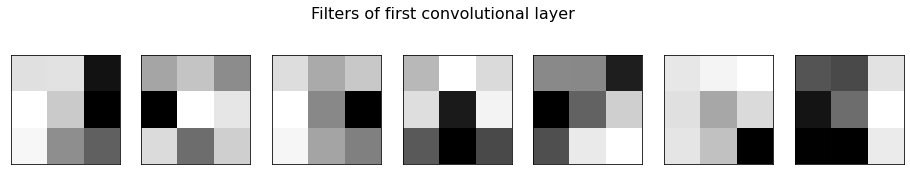

In [28]:
fig, ax = plt.subplots(1,int(best_net['n_channels']), figsize=(16, 3))

for i in range(int(best_net['n_channels'])):
    ax[i].imshow( weights_CV1[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters of first convolutional layer', fontsize=16)
plt.savefig('filters_CL1.png')
plt.show()

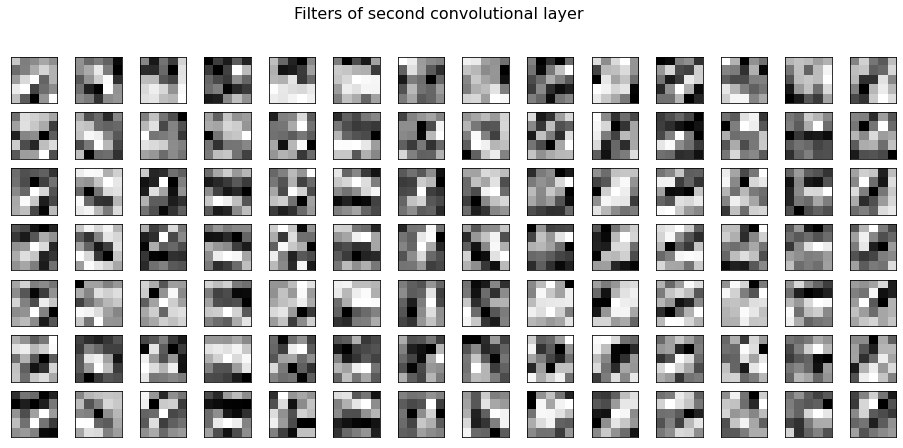

In [29]:
fig, ax = plt.subplots(int(best_net['n_channels']), 2*int(best_net['n_channels']), figsize=(16, 7))

for i in range(int(best_net['n_channels'])):
    for j in range(2*int(best_net['n_channels'])):
        ax[i,j].imshow( weights_CV2[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
fig.suptitle('Filters of second convolutional layer', fontsize=16)
plt.savefig('filters_CL2.png')
plt.show()

In [30]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [46]:
image_load = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = final_net.conv1.register_forward_hook(get_activation)

### Analyze activations
net = final_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = final_net(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()
print(act1.shape)

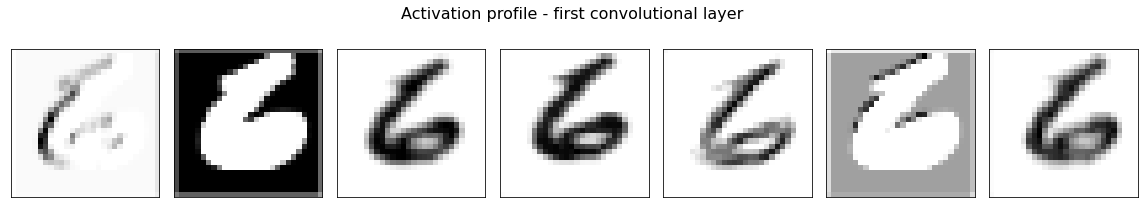

In [32]:
## Plot activations
fig, ax = plt.subplots(1, int(best_net['n_channels']), figsize=(16,3))
for i in range(int(best_net['n_channels'])):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CL1.png')
plt.show()   


In [33]:
### Register hook  
hook_handle = final_net.conv2.register_forward_hook(get_activation)

### Analyze activations
net = final_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x2 = s_batch[0].to(device)
        # Forward pass
        y2 = final_net(x2)
        z2 = activation

### Remove hook
hook_handle.remove()

act2 = z2.cpu().numpy()
print(act2.shape)

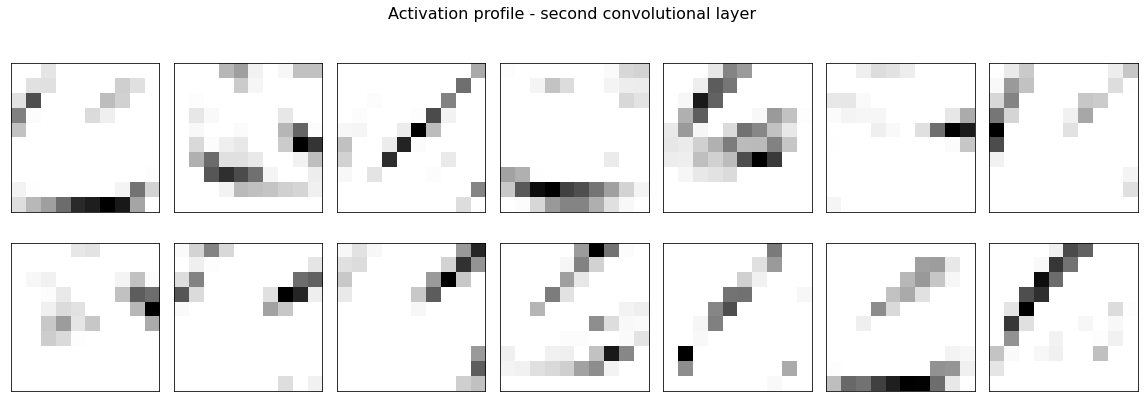

In [34]:
## Plot activations
fig, ax = plt.subplots(2, int(best_net['n_channels']), figsize=(16,6))

for i in range(int(best_net['n_channels'])):
    ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow( act2[0, i+int(best_net['n_channels']), :, :], cmap='Greys')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CL2.png')
plt.show()   

### ``final_net2``

In [50]:
weights_CV1 = final_net2.conv1.weight.data.cpu().numpy()
weights_CV2 = final_net2.conv2.weight.data.cpu().numpy()

print(weights_CV2.shape)

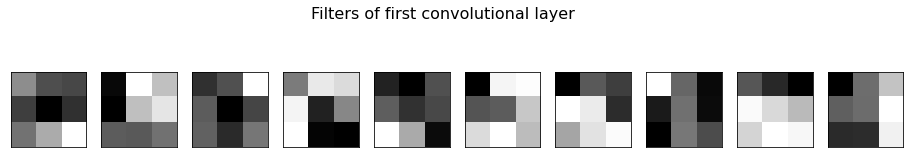

In [51]:
fig, ax = plt.subplots(1,int(best_net2['n_channels']), figsize=(16, 3))

for i in range(int(best_net2['n_channels'])):
    ax[i].imshow( weights_CV1[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters of first convolutional layer', fontsize=16)
plt.savefig('filters_CL1_2.png')
plt.show()

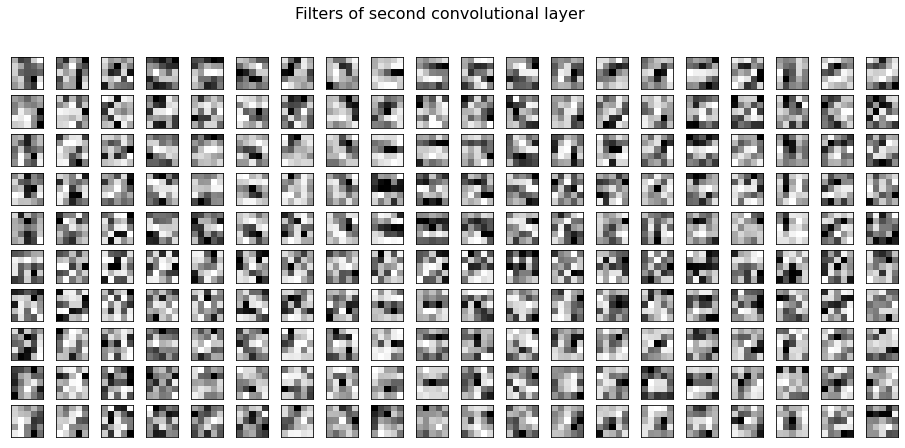

In [52]:
fig, ax = plt.subplots(int(best_net2['n_channels']), 2*int(best_net2['n_channels']), figsize=(16, 7))

for i in range(int(best_net2['n_channels'])):
    for j in range(2*int(best_net2['n_channels'])):
        ax[i,j].imshow( weights_CV2[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
fig.suptitle('Filters of second convolutional layer', fontsize=16)
plt.savefig('filters_CL2_2.png')
plt.show()

In [53]:
image_load = DataLoader(test_dataset, batch_size=1, shuffle=False) 

### Register hook  
hook_handle = final_net2.conv1.register_forward_hook(get_activation)

### Analyze activations
net = final_net2.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = final_net2(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()
print(act1.shape)

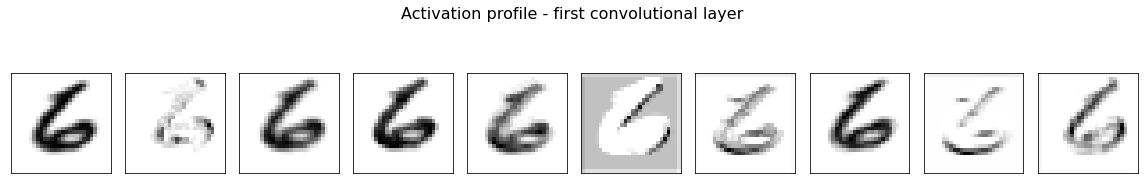

In [54]:
## Plot activations
fig, ax = plt.subplots(1, int(best_net2['n_channels']), figsize=(16,3))
for i in range(int(best_net2['n_channels'])):
    ax[i].imshow( act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CL1_2.png')
plt.show()   


In [55]:
### Register hook  
hook_handle = final_net2.conv2.register_forward_hook(get_activation)

### Analyze activations
net = final_net2.to(device)
net.eval()

with torch.no_grad():
    for s_batch in image_load:
        # Move data to device
        x2 = s_batch[0].to(device)
        # Forward pass
        y2 = final_net2(x2)
        z2 = activation

### Remove hook
hook_handle.remove()

act2 = z2.cpu().numpy()
print(act2.shape)

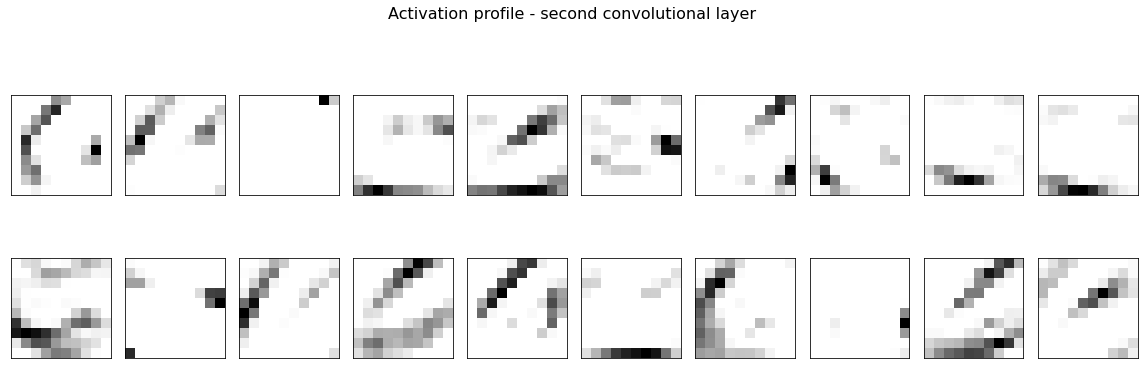

In [56]:
## Plot activations
fig, ax = plt.subplots(2, int(best_net2['n_channels']), figsize=(16,6))

for i in range(int(best_net2['n_channels'])):
    ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow( act2[0, i+int(best_net2['n_channels']), :, :], cmap='Greys')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
plt.tight_layout()
plt.savefig('activation_CL2_2.png')
plt.show()   

## Enhanced dataset

In [43]:
# I define some more tranformations to enhance the dataset: 
#  - a random rotation of an angle in the (-45°,45°) interval
#  - some gaussian noise, with kernel of 5 pixels
# The transformations are chosen randomly with the RandomChoice option, and then composed with the 
# first transformation

rotation_45 = torchvision.transforms.RandomRotation(45)
gauss_noise = torchvision.transforms.GaussianBlur(5)
choose_tran = torchvision.transforms.RandomChoice([rotation_45, gauss_noise])

transformation = torchvision.transforms.Compose( [ choose_tran, norm_transf] )

# apply transformation to datasets
train_set_full_tr = torchvision.datasets.MNIST('classifier_data', train=True, 
                                                download=True, transform=transformation)
test_dataset_tr   = torchvision.datasets.MNIST('classifier_data', train=False, 
                                                download=True, transform=transformation)
# define dataloaders
train_loader_tr = Data.DataLoader(train_set_full_tr, batch_size=batch_size_train, shuffle=True)

test_loader_tr  = Data.DataLoader(test_dataset_tr, batch_size=batch_size_test, shuffle=False)

In [44]:
# initialize network

net_tr = CNN(int(best_net['n_channels']), best_net['pdrop2d'], best_net['pdrop1d'] )
net_tr.to(device)
        
# initialize loss function
loss_func = nn.CrossEntropyLoss() 

# set up optimizer
if best_net['optimizer']=='adam':
    optz = optim.Adam(net_tr.parameters(), lr=best_net['learning_rate'], 
                     weight_decay=best_net['reg_param'])
elif best_net['optimizer']=='sgd':
    optz = optim.SGD(net_tr.parameters(), lr=best_net['learning_rate'], 
                    momentum=best_net['momentum'], weight_decay=best_net['reg_param'])
    
best_net['num_epochs'] = 50
best_net['device'] = device
verbose = True # see training process checkpoints

# Training and testing
train_loss_tr, test_loss_tr = final_net.fitting(train_loader_tr, test_loader_tr, optz,
                                                loss_func, verbose, best_net)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:51<42:27, 51.99s/it]

  4%|███▎                                                                               | 2/50 [01:47<43:08, 53.92s/it]

  6%|████▉                                                                              | 3/50 [02:41<42:26, 54.19s/it]

  8%|██████▋                                                                            | 4/50 [03:33<40:50, 53.28s/it]

 10%|████████▎                                                                          | 5/50 [04:24<39:16, 52.37s/it]

 12%|█████████▉                                                                         | 6/50 [05:17<38:40, 52.75s/it]

 14%|███████████▌                                                                       | 7/50 [06:17<39:27, 55.05s/it]

 14%|███████████▌                                                                       | 7/50 [07:10<44:05, 61.52s/it]


In [ ]:
# Plot training results
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].set_xlabel('Epoch', fontsize=24)
ax[0].set_ylabel('Loss', fontsize=24)
ax[1].set_xlabel('Epoch', fontsize=24)
ax[1].set_ylabel('Loss', fontsize=24)

ax[0].set_title('Best net - Losses vs. Epoch', fontsize=24)
ax[0].plot(train_loss_tr, label='train')
ax[0].plot(test_loss_tr, label='test')
ax[0].legend(loc='best', fontsize=14)

ax[1].set_title('Best net - Losses vs. Epoch, y-logscale', fontsize=24)
ax[1].semilogy(train_loss_tr, label='train')
ax[1].semilogy(test_loss_tr, label='test')
ax[1].legend(loc='best', fontsize=14)

plt.savefig('MNIST_enhanced_tr_test_loss_BEST.png')
plt.show()

In [ ]:
# store best parameters
net_state_dict = net_tr.state_dict()
torch.save(net_state_dict, 'best_net_parameters_enh.torch')
# save the optimizer state
torch.save(optz.state_dict(), 'optimizer_state_enh.torch')

In [ ]:
avg_test_loss_tr, accuracy_tr = testing(net_tr, test_loader_tr, loss_func, device)

In [ ]:
# Model  57

# Network parameters:
# {
#     'device': device(type='cpu'),
#     'num_epochs': 50,
#     'n_channels': 5,
#     'pdrop1d': 0.11774536456083606,
#     'pdrop2d': 0.07879246895944839,
#     'optimizer': 'adam',
#     'momentum': 0.9433182318841717,
#     'learning_rate': 1.1637764261975041e-05,
#     'reg_param': 0.0008225822412779581
# }


# Model  58

# Network parameters:
# {
#     'device': device(type='cpu'),
#     'num_epochs': 50,
#     'n_channels': 5,
#     'pdrop1d': 0.12542580413009127,
#     'pdrop2d': 0.07454809146395233,
#     'optimizer': 'adam',
#     'momentum': 0.7106043366130084,
#     'learning_rate': 0.002072045215475401,
#     'reg_param': 0.0001215961881871837
# }


